<a href="https://colab.research.google.com/github/michaeltsai25/shap_network_diagnosis/blob/main/mnist_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
from google.colab import files
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#set hyperparameters
n_epochs = 4
batch_size = 4
learning_rate = 0.001

#normalize dataset
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
num = 0

# set training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)

#selecting only classes 0 and 1, change for future experiments
idx = (train_dataset.targets == num) | (train_dataset.targets == num+1) #change
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)

#selecting classes 0 and 1 for the test dataset
idx = (test_dataset.targets == num) | (test_dataset.targets == num+1) #change
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader_1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=True)

#set classes (only training model to recognize zero or one for now)
classes = (str(num), str(num+1)) #change

In [ ]:
len(train_loader)

3167

In [ ]:
#initialize model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*4*4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

n_total_steps = len(train_loader)

In [ ]:
#testing to debug
im = train_dataset[0][0]
conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print(im.shape)
x = conv1(im)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([1, 28, 28])
torch.Size([6, 24, 24])
torch.Size([6, 12, 12])
torch.Size([16, 8, 8])
torch.Size([16, 4, 4])


In [ ]:
#training loop
for epoch in range(n_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels -= num #change for different experiments
    #forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 2000 == 0:
      print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/4], Step [2000], Loss: 0.2626
Epoch [2/4], Step [2000], Loss: 0.0044
Epoch [3/4], Step [2000], Loss: 0.0006
Epoch [4/4], Step [2000], Loss: 0.0007
Finished Training


In [ ]:
import numpy as np
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  predicted_cat = {0: [], 1: []}
  for images, labels in test_loader_1:
    images = images.to(device)
    labels = labels.to(device)
    labels -= num #change for different experiments
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)
    np_p = predicted.numpy()
    np_l = labels.numpy()
    # for l, p in zip(np_l, np_p):
    #   predicted_cat[l].append(p)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    size = labels.shape[0]
    for i in range(size):
      label = labels[i]
      pred = predicted[i]
      if (label==pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  '''
  tot_1 = np.unique(predicted_cat[0], return_counts=True)
  print(tot_1)
  tot_1 = tot_1[1].tolist()
  count, idx = max(tot_1), tot_1.index(max(tot_1))

  tot_2 = np.unique(predicted_cat[1], return_counts=True)
  print(tot_2)
  #tot_2 = tot_2[1].tolist()
  if idx == 0:
    count += tot_2[1]
  else:
    count += tot_2[0]

  acc = 100.0 * count / n_samples
  '''
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc}%')

  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc}%')

Accuracy of the network: 99.76359338061465%
Accuracy of 0: 99.6938775510204%
Accuracy of 1: 99.8237885462555%


In [ ]:
print(np.unique(predicted_cat[0], return_counts=True), np.unique(predicted_cat[1], return_counts=True))

(array([], dtype=float64), array([], dtype=int64)) (array([], dtype=float64), array([], dtype=int64))


In [ ]:


#model.fc3 = nn.Linear(84, 9)
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Zero-shot transferring

In [ ]:
import numpy as np

def test(num1, classes=None, n_digits=2, batch_size=4):
  # set training and testing datasets
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
  if n_digits != 10:
    #selecting only classes 0 and 1, change for future experiments
    idx = (train_dataset.targets == num1) | (train_dataset.targets == num1+1)
    train_dataset.targets = train_dataset.targets[idx]
    train_dataset.data = train_dataset.data[idx]

  test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=True, transform=transform)

  if n_digits != 10:
    #selecting classes 0 and 1 for the test dataset
    idx = (test_dataset.targets == num1) | (test_dataset.targets == num1+1)
    test_dataset.targets = test_dataset.targets[idx]
    test_dataset.data = test_dataset.data[idx]

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=True)

  #set classes (only training model to recognize zero or one for now)
  if (classes is None):
    classes = (str(num1), str(num1+1))

  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(n_digits)]
    n_class_samples = [0 for i in range(n_digits)]
    predicted_cat = {0: [], 1: []}
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      # labels -= num1 #change for different experiments
      outputs = model(images)

      _, predicted = torch.max(outputs, 1)
      # print(f'predicted: {predicted}')
      # print(f'labels: {labels}')
      '''
      np_p = predicted.numpy()
      np_l = labels.numpy()
      for l, p in zip(np_l, np_p):
        predicted_cat[l].append(p)
      '''
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()

      size = labels.shape[0]
      for i in range(size):
        label = labels[i]
        pred = predicted[i]
        if (label==pred):
          n_class_correct[label - num1] += 1
        n_class_samples[label - num1] += 1

    '''
    tot_1 = np.unique(predicted_cat[0], return_counts=True)
    print(tot_1)
    tot_1 = tot_1[1].tolist()

    count, idx = max(tot_1), tot_1.index(max(tot_1))

    tot_2 = np.unique(predicted_cat[1], return_counts=True)
    tot_2 = tot_2[1].tolist()
    if idx == 0 and len(tot_2) != 1:
      #print(tot_1)
      count += tot_2[1]
    else:
      count += tot_2[0]

    total_acc = 100.0 * count / n_samples
    #total_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {total_acc}%')
    '''
    total_acc = 100.0 * n_correct / n_samples
    for i in range(n_digits):
      if n_class_samples[i] != 0:
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      else:
        acc = 0
      print(f'Accuracy of {classes[i]}: {acc}%')
    return total_acc

#test(0)

In [ ]:
def training_loop(images, labels):
  images = images.to(device)
  labels = labels.to(device)
  # labels -= num1 #change for different experiments
  #forward pass
  outputs = model(images)
  loss = criterion(outputs, labels)

  #backward pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss

In [ ]:
def train(num1, select_all=False, n_epochs=4, batch_size=4, learning_rate=0.001, exp_replay=False):
  # set training and testing datasets
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

  # if exp_replay:
  #   td2 = train_dataset
  #   idx = (td2.targets == num1) | (td2.targets == num1+1)
  #   td2.targets = td2.targets[idx]
  #   td2.data = td2.data[idx]
  if exp_replay:
    td2 = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    indices = []
    for i in range(num1):
      if len(indices) == 0:
        indices = (td2.targets == i).numpy()
      else:
        indices = np.logical_or(indices, (td2.targets == i).numpy())
    td2.targets = td2.targets[indices]
    td2.data = td2.data[indices]

    tl2 = torch.utils.data.DataLoader(td2, batch_size=batch_size,
                                              shuffle=True)

  if select_all == False:
    #selecting only classes 0 and 1, change for future experiments
    idx = (train_dataset.targets == num1) | (train_dataset.targets == num1+1)
    train_dataset.targets = train_dataset.targets[idx]
    train_dataset.data = train_dataset.data[idx]

    #set classes (only training model to recognize zero or one for now)
    classes = (str(num1), str(num1+1))

  else:
    classes = tuple([str(i) for i in range(10)])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              shuffle=True)

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

  #training loop
  for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
      #print(f"outer loop {i}")
      #print(labels)
      loss = training_loop(images, labels)

      if exp_replay:
        '''
        im, lab = td2[randint(0, 3167)]
        lab = torch.tensor(lab, dtype=torch.int8)
        print(lab)
        '''
        for idx in range(2):
          #print(f"inner loop {idx}")
          im, lab = next(iter(tl2))
          training_loop(im, lab)

      #print(f"outer loop {i}")

      if (i+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
        break

  print('Finished Training')

Epoch [1/2], Step [200], Loss: 0.9519
Epoch [2/2], Step [200], Loss: 0.7327
Finished Training
Accuracy of 0: 98.46938775510205%
Accuracy of 1: 99.11894273127753%
Accuracy of 2: 73.64341085271317%
Accuracy of 3: 69.70297029702971%
Accuracy of 4: 0.0%
Accuracy of 5: 0.0%
Accuracy of 6: 0.0%
Accuracy of 7: 0.0%
Accuracy of 8: 0.0%
Accuracy of 9: 0.0%


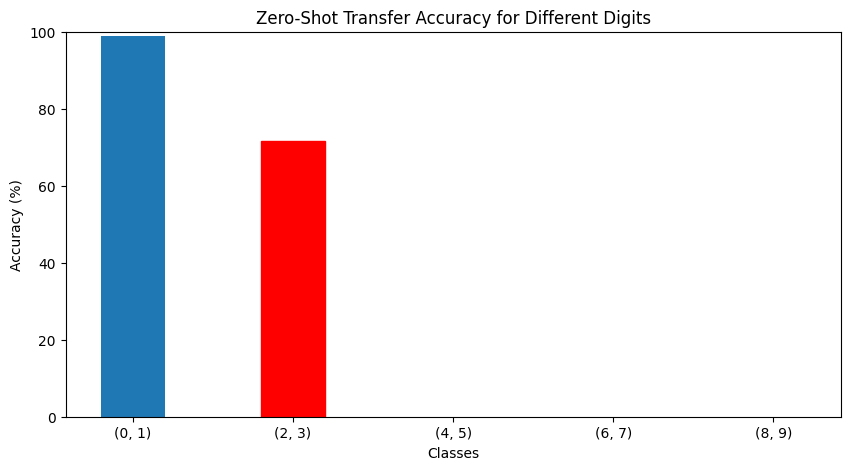

Epoch [1/2], Step [200], Loss: 1.0995
Epoch [2/2], Step [200], Loss: 0.8890
Finished Training
Accuracy of 0: 94.89795918367346%
Accuracy of 1: 97.62114537444934%
Accuracy of 2: 50.48449612403101%
Accuracy of 3: 95.14851485148515%
Accuracy of 4: 76.68024439918534%
Accuracy of 5: 50.336322869955154%
Accuracy of 6: 0.0%
Accuracy of 7: 0.0%
Accuracy of 8: 0.0%
Accuracy of 9: 0.0%


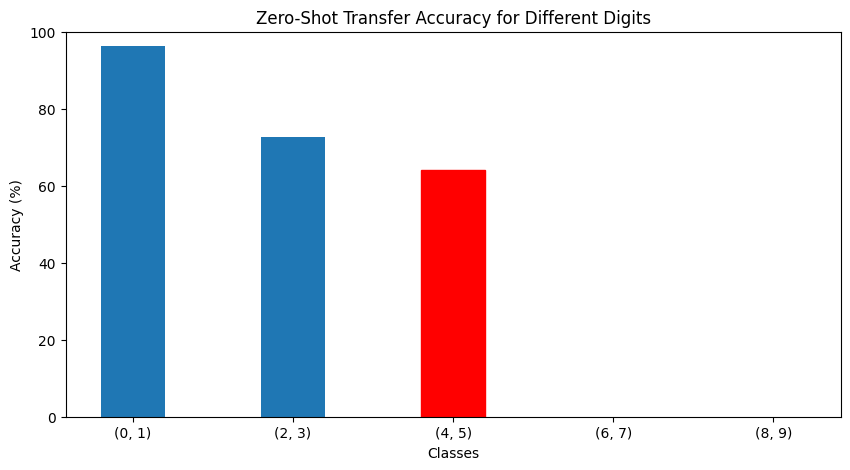

Epoch [1/2], Step [200], Loss: 0.9672
Epoch [2/2], Step [200], Loss: 0.4134
Finished Training
Accuracy of 0: 94.38775510204081%
Accuracy of 1: 96.2114537444934%
Accuracy of 2: 91.18217054263566%
Accuracy of 3: 79.5049504950495%
Accuracy of 4: 53.462321792260695%
Accuracy of 5: 61.771300448430495%
Accuracy of 6: 76.40918580375782%
Accuracy of 7: 80.54474708171206%
Accuracy of 8: 0.0%
Accuracy of 9: 0.0%


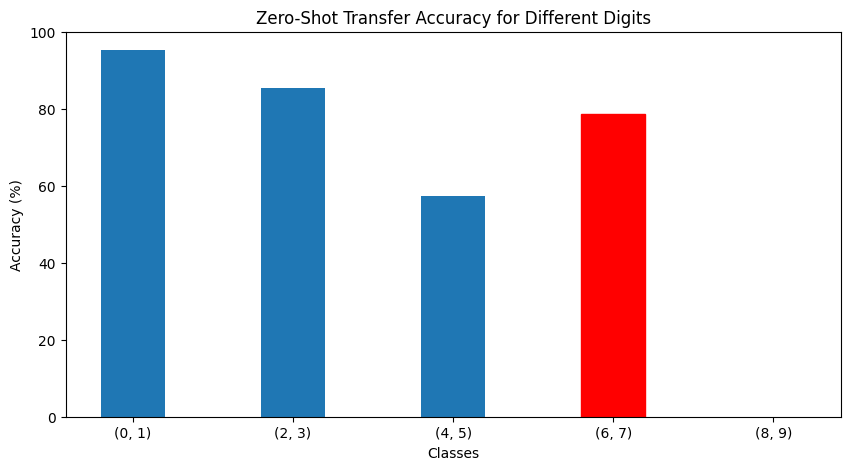

Epoch [1/2], Step [200], Loss: 0.9405
Epoch [2/2], Step [200], Loss: 0.9257
Finished Training
Accuracy of 0: 96.0204081632653%
Accuracy of 1: 93.568281938326%
Accuracy of 2: 90.60077519379846%
Accuracy of 3: 88.21782178217822%
Accuracy of 4: 44.09368635437882%
Accuracy of 5: 67.48878923766816%
Accuracy of 6: 82.4634655532359%
Accuracy of 7: 67.31517509727627%
Accuracy of 8: 66.52977412731006%
Accuracy of 9: 87.31417244796829%


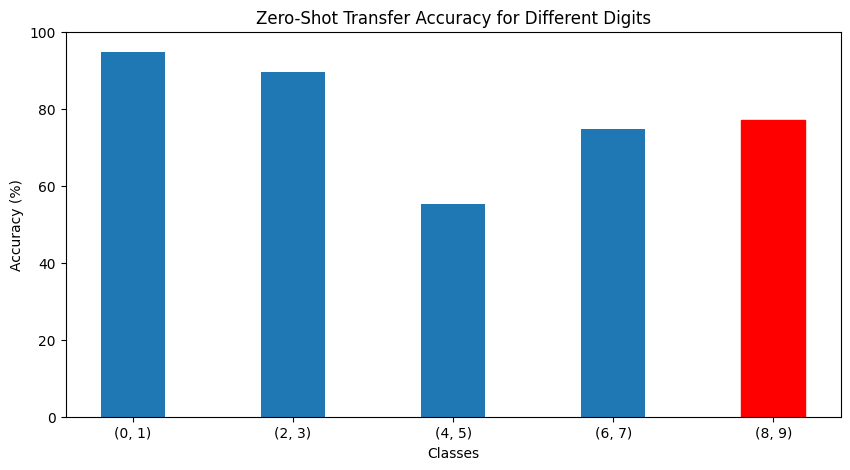

In [ ]:
x = 1
classes = [f"({str(i)}, {str(i+1)})" for i in range(0, 10, 2)]

for i in range(2, 10, 2):
  train(i, n_epochs=2, batch_size=4, learning_rate=0.001, exp_replay=True)
  acc_list = []
  for j in range(0, 10, 2):
    acc_list.append(test(j))

  fig = plt.figure(figsize=(10, 5))
  bars = plt.bar(classes, acc_list, width = 0.4)
  bars[x].set_color('red') #change
  plt.xlabel("Classes")
  plt.ylabel("Accuracy (%)")
  plt.title("Zero-Shot Transfer Accuracy for Different Digits")
  plt.ylim(0, 100)
  plt.show()
  x = x+1